# Rescaling the Data with tf–idf

Instead of dropping features that are deemed unimportant, another approach is to rescale features by how informative we expect them to be. One of the most common ways to do this is using the term frequency–inverse document frequency (tf–idf) method. The intuition of this method is to give high weight to any term that appears often in a particular document, but not in many documents in the corpus. If a word appears often in a particular document, but not in very many documents, it is likely to be very descriptive of the content of that document. scikit-learn implements the tf–idf method in two classes: TfidfTransformer, which takes in the sparse matrix output produced by CountVectorizer and transforms it, and TfidfVectorizer, which takes in the text data and does both the bag-of-words feature extraction and the tf–idf transformation.  The tf–idf score for word w in document d as implemented in both the TfidfTransformer and TfidfVectorizer classes is given by:

# tfidf(w,d)=tf * log((N+1)/(Nw+1))+1

where N is the number of documents in the training set, Nw is the number of documents in the training set that the word w appears in, and tf (the term frequency) is the number of times that the word w appears in the query document d (the document you want to transform or encode). Both classes also apply L2 normalization after computing the tf–idf representation; in other words, they rescale the representation of each document to have Euclidean norm 1. Rescaling in this way means that the length of a document (the number of words) does not change the vectorized representation.

Because tf–idf actually makes use of the statistical properties of the training data, we will use a pipeline, to ensure the results of our grid search are valid. This leads to the following code:

In [1]:
# Prepare and load dataset

# sklearn load_files function provide to load dataset from external file
from sklearn.datasets import load_files
review_train=load_files('dataset/')
# load_file returns a bunch, containing training texts and training labels
text_train,y_train=review_train.data,review_train.target

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe=make_pipeline(TfidfVectorizer(min_df=5,norm=None),LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid=GridSearchCV(pipe,param_grid,cv=5)
grid.fit(text_train,y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))

Best cross-validation score: 0.89


As you can see, there is some improvement when using tf–idf instead of just word counts. We can also inspect which words tf–idf found most important. Keep in mind that the tf–idf scaling is meant to find words that distinguish documents, but it is a purely unsupervised technique. So, “important” here does not necessarily relate to the “positive review” and “negative review” labels we are interested in. First, we extract the TfidfVectorizer from the pipeline:


In [3]:
import numpy as np

vecotorizer=grid.best_estimator_.named_steps['tfidfvectorizer']
# tansform the training dataset
X_train=vecotorizer.transform(text_train)
# find maximum value for each of the features over the dataset
max_value=X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf=max_value.argsort()
#get feature name
feature_name=np.array(vecotorizer.get_feature_names())

print('Features with lowest tfidf:\n{}'.format(feature_name[sorted_by_tfidf[:20]]))
print('Features with highest tfidf:\n{}'.format(feature_name[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['poignant' 'disagree' 'instantly' 'importantly' 'lacked' 'occurred'
 'currently' 'altogether' 'nearby' 'undoubtedly' 'directs' 'fond'
 'stinker' 'avoided' 'emphasis' 'commented' 'disappoint' 'realizing'
 'downhill' 'inane']
Features with highest tfidf:
['coop' 'homer' 'dillinger' 'hackenstein' 'gadget' 'taker' 'macarthur'
 'vargas' 'jesse' 'basket' 'dominick' 'the' 'victor' 'bridget' 'victoria'
 'khouri' 'zizek' 'rob' 'timon' 'titanic']


Features with low tf–idf are those that either are very commonly used across documents or are only used sparingly, and only in very long documents. Interestingly, many of the high-tf–idf features actually identify certain shows or movies. These terms only appear in reviews for this particular show or franchise, but tend to appear very often in these particular reviews. This is very clear, for example, for "pokemon", "smallville", and "doodlebops", but "scanners" here actually also refers to a movie title. These words are unlikely to help us in our sentiment classification task (unless maybe some franchises are universally reviewed positively or negatively) but certainly contain a lot of specific information about the reviews.

We can also find the words that have low inverse document frequency—that is, those that appear frequently and are therefore deemed less important. The inverse document frequency values found on the training set are stored in the idf_ attribute:


In [4]:
sorted_by_idf=np.argsort(vecotorizer.idf_)
print('Features with lowest idf:\n{}'.format(feature_name[sorted_by_idf[:100]]))

Features with lowest idf:
['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'br' 'have' 'one' 'be' 'film' 'are' 'you'
 'all' 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his'
 'out' 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more'
 'when' 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really'
 'story' 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were'
 'other' 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how'
 'great' 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after'
 'any' 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen'
 'its']


As expected, these are mostly English stopwords like "the" and "no". But some are clearly domain-specific to the movie reviews, like "movie", "film", "time", "story", and so on. Interestingly, "good", "great", and "bad" are also among the most frequent and therefore “least relevant” words according to the tf–idf measure, even though we might expect these to be very important for our sentiment analysis task. 

# Investigating Model Coefficients

Finally, let’s look in a bit more detail into what our logistic regression model actually learned from the data. Because there are so many features—27,271 after removing the infrequent ones—we clearly cannot look at all of the coefficients at the same time. However, we can look at the largest coefficients, and see which words these correspond to. We will use the last model that we trained, based on the tf–idf features.

The following bar chart Figure shows the 25 largest and 25 smallest coefficients of the logistic regression model, with the bars showing the size of each coefficient:

In [5]:
import mglearn
mglearn.tools.visualize_coefficients(grid.best_estimator_.named_steps["logisticregression"].coef_,
                                     feature_names=feature_name,n_top_features=40)

    Largest and smallest coefficients of logistic regression trained on tf-idf features

The negative coefficients on the left belong to words that according to the model are indicative of negative reviews, while the positive coefficients on the right belong to words that according to the model indicate positive reviews. Most of the terms are quite intuitive, like "worst", "waste", "disappointment", and "laughable" indicating bad movie reviews, while "excellent", "wonderful", "enjoyable", and "refreshing" indicate positive movie reviews. Some words are slightly less clear, like "bit", "job", and "today", but these might be part of phrases like “good job” or “best today.” 

# Bag-of-Words with More Than One Word (n-Grams)

One of the main disadvantages of using a bag-of-words representation is that word order is completely discarded. Therefore, the two strings “it’s bad, not good at all” and “it’s good, not bad at all” have exactly the same representation, even though the meanings are inverted. Putting “not” in front of a word is only one example (if an extreme one) of how context matters. Fortunately, there is a way of capturing context when using a bag-of-words representation, by not only considering the counts of single tokens, but also the counts of pairs or triplets of tokens that appear next to each other. Pairs of tokens are known as bigrams, triplets of tokens are known as trigrams, and more generally sequences of tokens are known as n-grams. We can change the range of tokens that are considered as features by changing the ngram_range parameter of CountVectorizer or TfidfVectorizer. The ngram_range parameter is a tuple, consisting of the minimum length and the maximum length of the sequences of tokens that are considered. Here is an example on the toy data we used earlier:

In [6]:
bard_words=["The fool doth think he is wise,",
           "but the wise man knows himself to be a fool"]

print("bards_words:\n{}".format(bard_words))

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv=CountVectorizer(ngram_range=(1,1)).fit(bard_words)
print("Vocabulary size: {}".format(len(cv.get_feature_names())))
print("Vocabulary: \n{}".format(cv.get_feature_names()))

Vocabulary size: 13
Vocabulary: 
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [8]:
cv=CountVectorizer(ngram_range=(2,2)).fit(bard_words)
print("Vocabulay size: {}".format(len(cv.vocabulary_)))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulay size: 14
Vocabulary:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


Using longer sequences of tokens usually results in many more features, and in more specific features. There is no common bigram between the two phrases in bard_words:

In [9]:
print("Transformed data (dense):\n{}".format(cv.transform(bard_words).toarray()))

Transformed data (dense):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


For most applications, the minimum number of tokens should be one, as single words often capture a lot of meaning. Adding bigrams helps in most cases. Adding longer sequences—up to 5-grams—might help too, but this will lead to an explosion of the number of features and might lead to overfitting, as there will be many very specific features. In principle, the number of bigrams could be the number of unigrams squared and the number of trigrams could be the number of unigrams to the power of three, leading to very large feature spaces. In practice, the number of higher n-grams that actually appear in the data is much smaller, because of the structure of the (English) language, though it is still large.

Here is what using unigrams, bigrams, and trigrams on bards_words looks like:

In [10]:
cv=CountVectorizer(ngram_range=(1,3)).fit(bard_words)
print("Vocabulary size: {}".format(cv.vocabulary_))
print("Vocabulary:\n{}".format(cv.get_feature_names()))

Vocabulary size: {'the': 25, 'fool': 8, 'doth': 5, 'think': 30, 'he': 11, 'is': 17, 'wise': 36, 'the fool': 26, 'fool doth': 9, 'doth think': 6, 'think he': 31, 'he is': 12, 'is wise': 18, 'the fool doth': 27, 'fool doth think': 10, 'doth think he': 7, 'think he is': 32, 'he is wise': 13, 'but': 2, 'man': 22, 'knows': 19, 'himself': 14, 'to': 33, 'be': 0, 'but the': 3, 'the wise': 28, 'wise man': 37, 'man knows': 23, 'knows himself': 20, 'himself to': 15, 'to be': 34, 'be fool': 1, 'but the wise': 4, 'the wise man': 29, 'wise man knows': 38, 'man knows himself': 24, 'knows himself to': 21, 'himself to be': 16, 'to be fool': 35}
Vocabulary:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise'

Let’s try out the TfidfVectorizer on the IMDb movie review data and find the best setting of n-gram range using a grid search:


In [12]:
pipe=make_pipeline(TfidfVectorizer(min_df=5),LogisticRegression())
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams

param_grid = {"logisticregression__C": [0.001, 0.01, 0.1, 1, 10, 100], 
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid=GridSearchCV(pipe,param_grid=param_grid,cv=5)
grid.fit(text_train,y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameter:\n{}".format(grid.best_params_))

Best cross-validation score: 0.91
Best parameter:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


As you can see from the results, we improved performance by a bit more than a percent by adding bigram and trigram features. We can visualize the cross-validation accuracy as a function of the ngram_range and C parameter as a heat map.

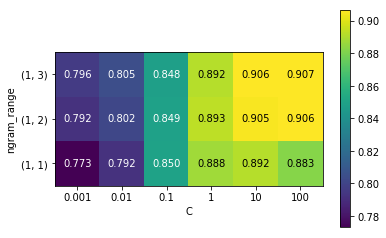

In [13]:
import mglearn
import matplotlib.pyplot as plt
# exact score from grid_search

scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(   
    scores, xlabel="C", ylabel="ngram_range", 
    cmap="viridis", fmt="%.3f",  
    xticklabels=param_grid['logisticregression__C'], 
    yticklabels=param_grid['tfidfvectorizer__ngram_range']) 
plt.colorbar(heatmap)

From the heat map we can see that using bigrams increases performance quite a bit, while adding trigrams only provides a very small benefit in terms of accuracy. To understand better how the model improved, we can visualize the important cofficient for the best model, which includes unigrams, bigrams and trigrams

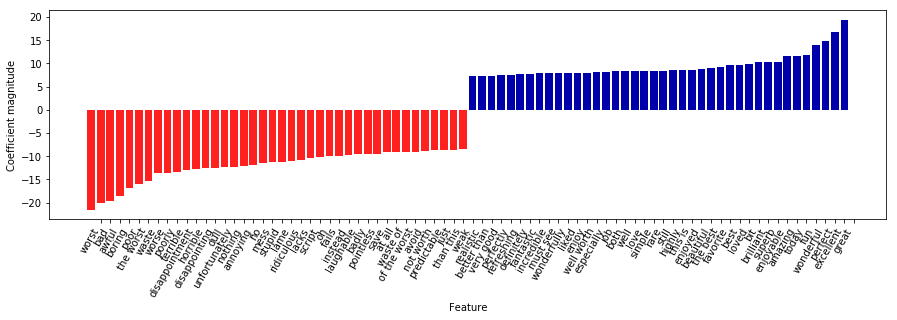

In [17]:
vect=grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names=np.array(vect.get_feature_names())
coef=grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef,feature_names,n_top_features=40)

There are particularly interesting features containing the word “worth” that were not present in the unigram model: "not worth" is indicative of a negative review, while "definitely worth" and "well worth" are indicative of a positive review. This is a prime example of context influencing the meaning of the word “worth.” Next, we’ll visualize only trigrams, to provide further insight into why these features are helpful. Many of the useful bigrams and trigrams consist of common words that would not be informative on their own, as in the phrases "none of the", "the only good", "on and on", "this is one", "of the most", and so on. However, the impact of these features is quite limited compared to the importance of the unigram features, as you can see in figure:

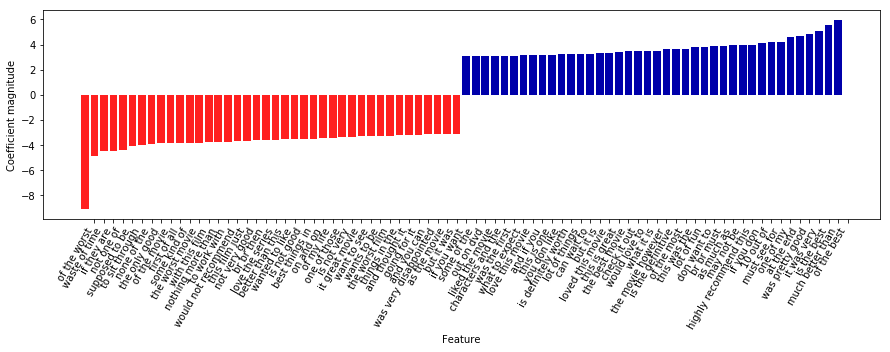

In [19]:
# find 3 gram features
mask=np.array([len(feature.split(" ")) for feature in feature_names])==3
#visualize only 3-gram features
mglearn.tools.visualize_coefficients(coef.ravel()[mask],feature_names[mask],n_top_features=40)